In [22]:
import copy 
import json

ATTACK = '1'
BENIGN = '0'

with open("../../data/pre_process/dissection_clean/both.json") as f:
    my_json = json.load(f)

types = [
    "discovery",
    "addNf",
    "removeNf",
    "fuzzing",
    "sessionDeletion",
    "sessionModification",
    "sessionEstablishment",
    "gtp",
    "pfcp_in_gtp",
    "seid_fuzzing",
    "other"
]

sequences = []


for dissected_pkt in my_json:

    found = False
    is_attack = dissected_pkt["common"]["is_attack"]

    if "http2" in dissected_pkt["protocols"]:

        for layer in dissected_pkt["protocols"]["http2"]:

            if "path" in layer:

                # Discovery Requests
                if "/nnrf-disc" in layer["path"]:
                    sequences.append((is_attack,types.index("discovery")))
                    found = True

                # Add and remove NF Requests
                if "/nnrf-nfm" in layer["path"]:

                    if layer["method"] == "PUT":
                        sequences.append((is_attack,types.index("addNf")))
                        found = True

                    elif layer["method"] == "DELETE":
                        sequences.append((is_attack,types.index("removeNf")))
                        found = True

                # Any fuzzing request
                if "/nudm" in layer["path"] or "/namf" in layer["path"]:
                    sequences.append((is_attack,types.index("fuzzing")))
                    found = True

    if "pfcp" in dissected_pkt["protocols"]:

        for layer in dissected_pkt["protocols"]["pfcp"]:

            if "msg_type" in layer:

                # PFCP Deletion Requests
                if int(layer["msg_type"]) == 54:
                    sequences.append((is_attack,types.index("sessionDeletion")))
                    found = True

                # PFCP Modification Requests
                if int(layer["msg_type"]) == 52:

                    if int(is_attack):

                        if dissected_pkt["common"]["type"] == "seid_fuzzing":
                            sequences.append((is_attack,types.index("seid_fuzzing")))
                            found = True
                        else :
                            sequences.append((is_attack,types.index("sessionModification")))
                            found = True
                    else:
                        sequences.append((is_attack,types.index("seid_fuzzing")))
                        sequences.append((is_attack,types.index("sessionModification")))
                        found = True

                # PFCP Establishment Requests
                if int(layer["msg_type"]) == 50:
                    sequences.append((is_attack,types.index("sessionEstablishment")))
                    found = True

    if "gtp" in dissected_pkt["protocols"]:

            for layer in dissected_pkt["protocols"]["gtp"]:

                # PFCP IN GTP
                # We take only the request not the responses
                # (Because the response are not sent to the EVIL)
                if "pfcp" in dissected_pkt["protocols"] and int(dissected_pkt["protocols"]["pfcp"][0]["msg_type"]) == 5:
                    sequences.append((is_attack,types.index("pfcp_in_gtp")))
                    found = True

                else:
                    sequences.append((is_attack,types.index("gtp")))
                    found = True

    if not found:
        sequences.append((is_attack,types.index("other")))

In [23]:
import pandas as pd

df = pd.DataFrame(sequences, columns=["is_attack", "type_index"])
df

,is_attack,type_index
0,0,10
1,0,10
2,0,10
3,0,10
4,0,0
...,...,...
95196,1,10
95197,1,10
95198,1,1
95199,1,10


In [16]:
filtered = df[(df['is_attack'] == BENIGN) & (df['type_index'] == types.index("discovery"))]
groups_with_duplicates = filtered['group'].value_counts()
groups_with_duplicates = groups_with_duplicates[groups_with_duplicates >= 2].index

result = filtered[filtered['group'].isin(groups_with_duplicates)]
result

,is_attack,type_index,group
0,0,0,1
1,0,0,1
13,0,0,9
14,0,0,9
15,0,0,9
...,...,...,...
15207,0,0,5568
15209,0,0,5570
15210,0,0,5570
15211,0,0,5570


is_attack               0    1
discovery             1.0  1.0
addNf                 1.0  1.0
removeNf              1.0  1.0
fuzzing               1.0  1.0
sessionDeletion       1.0  1.0
sessionModification   1.0  1.0
sessionEstablishment  1.0  1.0
gtp                   2.0  1.0
seid_fuzzing          1.0  1.0
other                 9.0  1.0


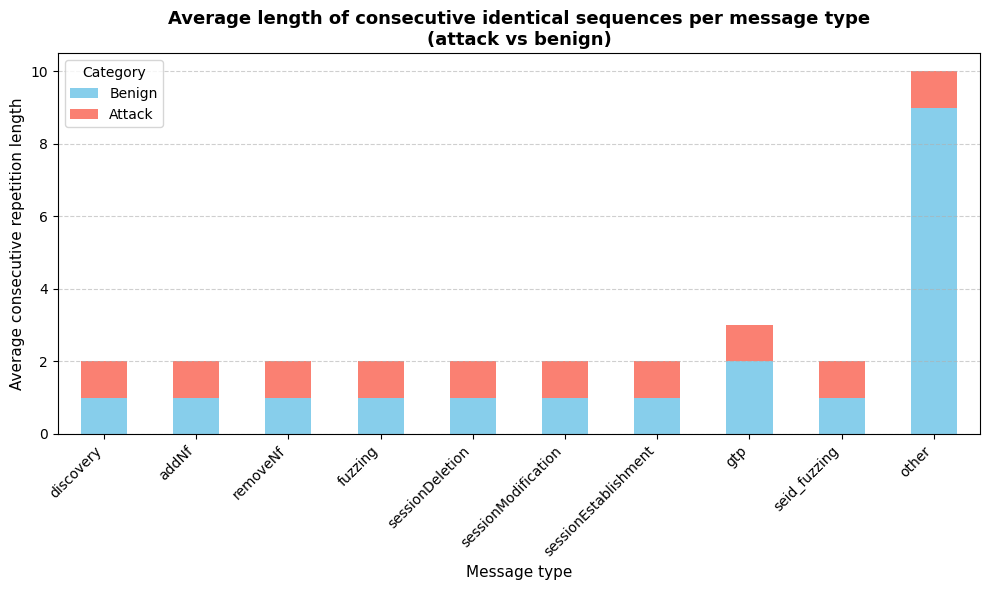

In [24]:
import matplotlib.pyplot as plt


# --- 1️⃣ Identifier les séquences consécutives identiques ---
# Quand la paire change, on crée un nouvel ID de groupe
df["group"] = (df[["is_attack", "type_index"]] != df[["is_attack", "type_index"]].shift()).any(axis=1).cumsum()

# --- 2️⃣ Calculer la longueur de chaque séquence ---
seq_lengths = df.groupby(["group", "is_attack", "type_index"]).size().reset_index(name="length")

# --- 3️⃣ Moyenne des longueurs par type et statut ---
avg_lengths = (
    seq_lengths.groupby(["type_index", "is_attack"])["length"]
    .mean()
    .unstack(fill_value=0)
)

# --- 4️⃣ Remplacer les indices par les labels de `types` ---
avg_lengths.index = [types[i] for i in avg_lengths.index]
avg_lengths.columns = ["benign", "attack"] if 0 in avg_lengths.columns else avg_lengths.columns

avg_lengths = avg_lengths.round()   # <= ici, arrondi à 2 décimales

print(avg_lengths)

# --- 5️⃣ Visualisation : barres empilées ---
plt.figure(figsize=(10, 6))
avg_lengths.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], ax=plt.gca())

plt.title("Average length of consecutive identical sequences per message type\n(attack vs benign)",
          fontsize=13, fontweight='bold')
plt.xlabel("Message type", fontsize=11)
plt.ylabel("Average consecutive repetition length", fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Category", labels=["Benign", "Attack"])
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()

In [19]:
avg_repeats

{'discovery': 2.0,
 'addNf': 1.3333333333333333,
 'removeNf': 1.1666666666666667,
 'fuzzing': 3.0,
 'sessionDeletion': 110.55172413793103,
 'sessionModification': 1.3863636363636365,
 'sessionEstablishment': 104.47619047619048,
 'gtp': 1.1333333333333333,
 'pfcp_in_gtp': 1.2,
 'seid_fuzzing': 105.16129032258064}